In [1]:
import pandas as pd
import numpy as np
import requests
from functools import reduce
from io import StringIO
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM, s, f
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SequentialFeatureSelector
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from data_preparation.additional_transformers import GiniSelector
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.preprocessing import FunctionTransformer

In [2]:
from data_preparation.transform_features import full_pipeline_ml, remove_nans, full_pipeline_logisitic
from feature_engine.encoding import WoEEncoder

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [19]:
train_data = pd.read_csv("https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv")
train_data_no_nans = remove_nans(train_data)
y_train = train_data_no_nans[1]
X_train = train_data_no_nans[0]
print(X_train.shape, y_train.shape)
X_train = full_pipeline_ml.fit_transform(X_train)
print(X_train.shape, y_train.shape)


test_data = pd.read_csv("https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv")
test_data_no_nans = remove_nans(test_data)
y_test = test_data_no_nans[1]
X_test = test_data_no_nans[0]
print(X_test.shape, y_test.shape)
X_test = full_pipeline_ml.transform(X_test)
print(X_test.shape, y_test.shape)
print(X_test.columns)

columns_to_drop = ['scale__remainder___r_']
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)
print(X_train.shape)
                  

(36122, 34) (36122,)


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


(36122, 61) (36122,)
(3606, 34) (3606,)
(3606, 61) (3606,)
Index(['scale__zero_fill__Application data: income of second applicant',
       'scale__zero_fill__Value of the goods (car)',
       'scale__fill_zeros_but_add_var__Amount on current account',
       'scale__fill_zeros_but_add_var__Amount on savings account',
       'scale__remainder__Number of applicants',
       'scale__remainder__Application amount',
       'scale__remainder__Credit duration (months)',
       'scale__remainder__Payment frequency',
       'scale__remainder__Installment amount',
       'scale__remainder__Application data: income of main applicant',
       'scale__remainder__Application data: number of children of main applicant',
       'scale__remainder__Application data: number of dependences of main applicant',
       'scale__remainder__Spendings estimation',
       'scale__remainder__Number of requests during the last 3 months (External data)',
       'scale__remainder__Number of requests during the last 6

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {                 
    'interactions': [0.0, 0.9, 1],             
    'max_leaves': [2, 3, 6]               
}

ebm = ExplainableBoostingClassifier()

grid_search = GridSearchCV(estimator=ebm, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....interactions=0.0, max_leaves=2;, score=0.751 total time=  34.6s
[CV 2/3] END ....interactions=0.0, max_leaves=2;, score=0.763 total time=  47.0s
[CV 3/3] END ....interactions=0.0, max_leaves=2;, score=0.752 total time=  37.0s
[CV 1/3] END ....interactions=0.0, max_leaves=3;, score=0.747 total time=  19.5s
[CV 2/3] END ....interactions=0.0, max_leaves=3;, score=0.761 total time=  18.8s
[CV 3/3] END ....interactions=0.0, max_leaves=3;, score=0.751 total time=  19.4s
[CV 1/3] END ....interactions=0.0, max_leaves=6;, score=0.738 total time=  16.3s
[CV 2/3] END ....interactions=0.0, max_leaves=6;, score=0.745 total time=  15.6s
[CV 3/3] END ....interactions=0.0, max_leaves=6;, score=0.742 total time=  16.3s
[CV 1/3] END ....interactions=0.9, max_leaves=2;, score=0.762 total time=  37.0s
[CV 2/3] END ....interactions=0.9, max_leaves=2;, score=0.769 total time=  47.0s
[CV 3/3] END ....interactions=0.9, max_leaves=2;,

In [15]:
ebm = ExplainableBoostingClassifier(max_rounds=6000, learning_rate=0.022, interactions=1, max_leaves=2)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(interactions=1, learning_rate=0.022, max_leaves=2,
                              max_rounds=6000)

In [6]:
from data_preparation.metrics_eval import get_predictions_proba, get_predictions_test, evaluate_model, specificity_score, find_best_threshold, confusion_matrices

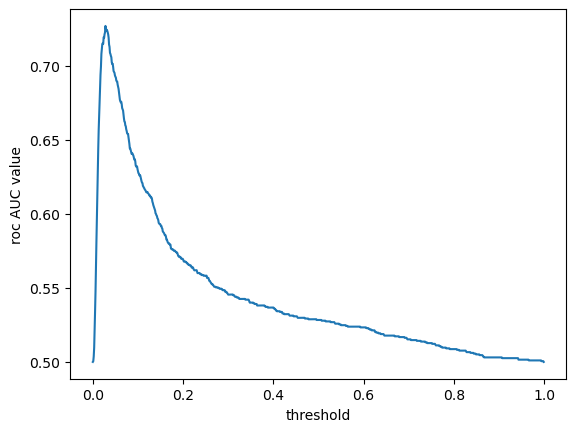

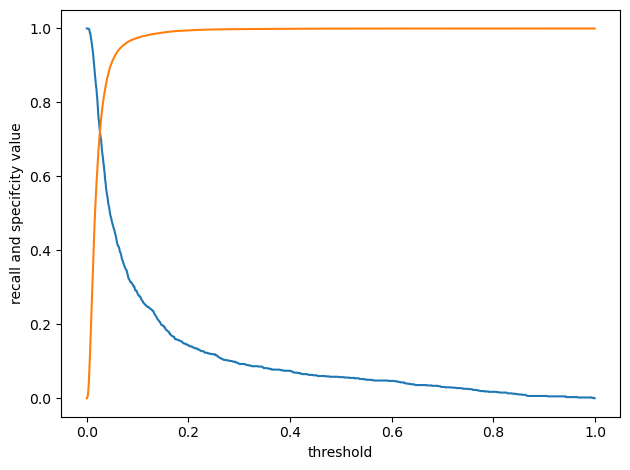

(0.028, 0.7270840988678396)


In [16]:
print(find_best_threshold(y_train, get_predictions_proba(ebm, X_train)))

In [13]:
print(evaluate_model(ebm, X_train, y_train, X_test, y_test, threshold=0.028))

Evaluating model: ExplainableBoostingClassifier
                           Model Dataset       AUC  Accuracy  Precision  \
0  ExplainableBoostingClassifier   Train  0.826047  0.774846   0.082545   
1  ExplainableBoostingClassifier    Test  0.783777  0.766778   0.081515   

     Recall  F1-score  
0  0.719959  0.148109  
1  0.633929  0.144456  


Evaluating model: ExplainableBoostingClassifier


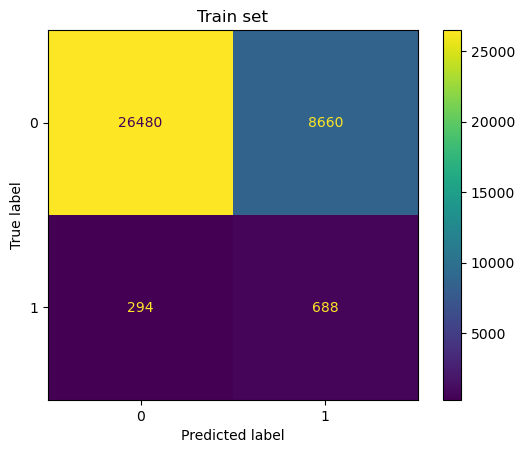

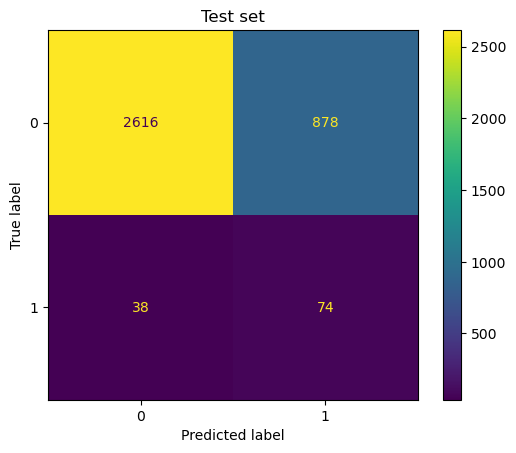

None


target
0.0    3494
1.0     112
Name: count, dtype: int64

In [18]:
print(confusion_matrices(ebm, X_train, y_train, X_test, y_test, threshold=0.028))
y_test.value_counts()

In [1]:
print(confusion_matrices(ebm, X_train, y_train, X_test, y_test))

NameError: name 'confusion_matrices' is not defined

In [57]:
def localsum(x):
    total=x[0]
    for i in range(1,len(x)):
        total+=x[i]
    return total
    
gam = LogisticGAM(localsum([s(i) for i in range(34)])).fit(X, y)

AUC (Train): 0.8224110872969517
Accuracy (Train): 0.9710768560379106
Precision (Train): 0.773109243697479
Recall (Train): 0.08163265306122448
F1-score (Train): 0.14767255216693417
AUC (Test): 0.7762805698401016
Accuracy (Test): 0.9668220455168631
Precision (Test): 0.0
Recall (Test): 0.0
F1-score (Test): 0.0


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=.95)

    # Plot partial dependence
    ax = axes[i]
    ax.plot(XX[:, term.feature], pdep)
    ax.set_title(f'Partial Dependence for Term {i}')
    ax.set_xlabel(f'Feature {term.feature}')
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()  # Adjust subplot parameters for better layout
plt.show()